In [58]:
import random
import time
import torch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from src.model.base import NeuralNetwork
from src.model.layer import Input, FullyConnected
from src.model.loss import CategoricalCrossEntropy
from src.model.optimizer import Adam
from src.model.activation import LeakyRelu, Linear
from src.model.metric import AccuracyOneHot

## Helper functions for displaying changes in loss and Accuracy with the change of epochs

In [59]:
def plot_loss(epoch, train_loss, test_loss, title):         
    plt.figure(figsize=(10, 8))
    plt.plot(epoch, train_loss, color='r', label='Train')
    plt.plot(epoch, test_loss, color='g', label='Test')
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_accuracy_score(epoch, train_metric, test_metric, title):         
    plt.figure(figsize=(10, 8))
    plt.plot(epoch, train_metric, color='r', label='Train')
    plt.plot(epoch, test_metric, color='g', label='Test')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.show()

# 1. Classification on full iris dataset

## Function to display selected iris sample data with species shown on the sepal width - sepal height and petal width - petal height coordinates

In [60]:
def plot_iris(data, title):

    sepal_length, sepal_width, petal_length, petal_width, colors = [], [], [], [], []

    for row in data:
        sepal_length.append(row['input'][0])
        sepal_width.append(row['input'][1])
        petal_length.append(row['input'][2])
        petal_width.append(row['input'][3])
        if row['output'] == [1.0, 0.0, 0.0]:
            color = 'red'
        elif row['output'] == [0.0, 1.0, 0.0]:
            color = 'blue'
        else:
            color = 'orange'
        colors.append(color)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    ax1.scatter(sepal_length, sepal_width, c=colors, alpha=0.5)
    red_patch = mpatches.Patch(color='red', label='Iris-setosa')
    blue_patch = mpatches.Patch(color='blue', label='Iris-versicolor')
    orange_patch = mpatches.Patch(color='orange', label='Iris-virginica')
    ax1.legend(handles=[red_patch, blue_patch, orange_patch], title="Species")
    ax1.set_title(f"{title} in sepal coordinates")
    ax1.set_xlabel("sepal_length")
    ax1.set_ylabel("sepal_width")

    ax2.scatter(petal_length, petal_width, c=colors, alpha=0.5)
    ax2.legend(handles=[red_patch, blue_patch, orange_patch], title="Species")
    ax2.set_title(f"{title} in petal coordinates")
    ax2.set_xlabel("petal_length")
    ax2.set_ylabel("petal_width")

    plt.tight_layout()
    plt.show()

    return

## Function to obtain an iris dataset

In [61]:
def get_iris_dataset():
    data = pd.read_csv('../data/iris/Iris.csv')
    data.drop('Id', axis=1, inplace=True)
    feature_columns = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
    for feature_column in feature_columns:
        data[feature_column] = (data[feature_column] - data[feature_column].min())/(data[feature_column].max() - data[feature_column].min())

    one_hot_map = {
        'Iris-setosa': [1.0, 0.0, 0.0],
        'Iris-versicolor': [0.0, 1.0, 0.0],
        'Iris-virginica': [0.0, 0.0, 1.0],
    }

    dataset = []
    for index in data.index:
        input_values = [float(val) for val in data.loc[index].drop('Species').values]
        specie = one_hot_map[data.loc[index, 'Species']]
        dataset.append({
            'input': input_values,
            'output': specie
        })

    random.shuffle(dataset)
    return dataset[:115], dataset[115:]

## Create model for classification on iris dataset and test

Epoch: 1/30, train loss: 0.8789, train Accuracy: 0.7826, test loss: 0.7663, test Accuracy: 0.7429
Epoch: 2/30, train loss: 0.6865, train Accuracy: 0.9478, test loss: 0.6865, test Accuracy: 0.8571
Epoch: 3/30, train loss: 0.6548, train Accuracy: 0.9478, test loss: 0.6315, test Accuracy: 0.9143
Epoch: 4/30, train loss: 0.6085, train Accuracy: 0.9652, test loss: 0.6304, test Accuracy: 0.9714
Epoch: 5/30, train loss: 0.6057, train Accuracy: 0.9739, test loss: 0.6125, test Accuracy: 0.9429
Epoch: 6/30, train loss: 0.6016, train Accuracy: 0.9565, test loss: 0.6086, test Accuracy: 0.9714
Epoch: 7/30, train loss: 0.5945, train Accuracy: 0.9652, test loss: 0.6044, test Accuracy: 0.9714
Epoch: 8/30, train loss: 0.6036, train Accuracy: 0.9652, test loss: 0.6211, test Accuracy: 0.9429
Epoch: 9/30, train loss: 0.5942, train Accuracy: 0.9652, test loss: 0.6023, test Accuracy: 0.9429
Epoch: 10/30, train loss: 0.5944, train Accuracy: 0.9739, test loss: 0.5828, test Accuracy: 0.9714
Epoch: 11/30, train

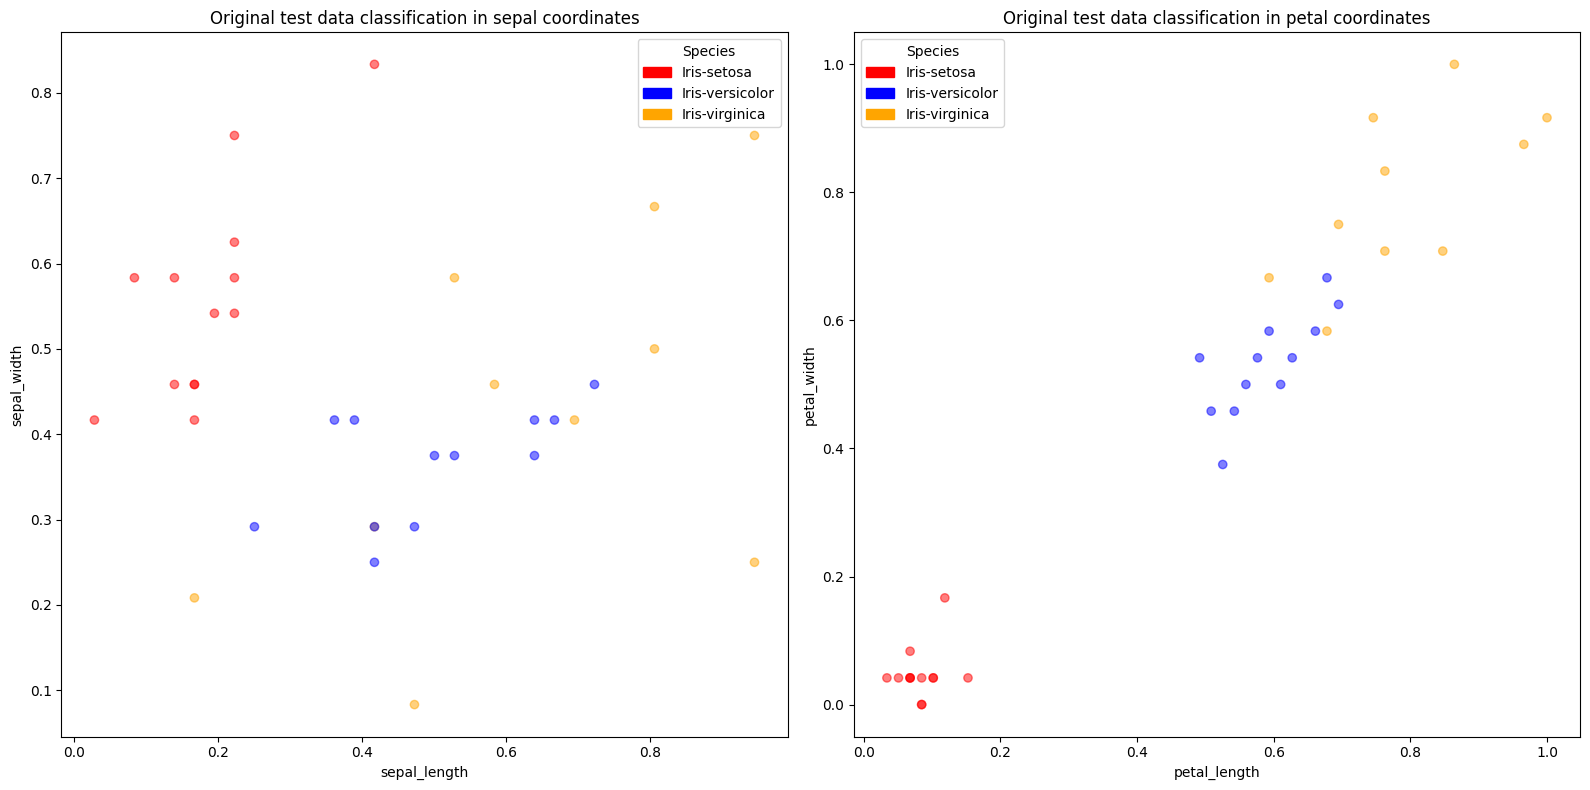

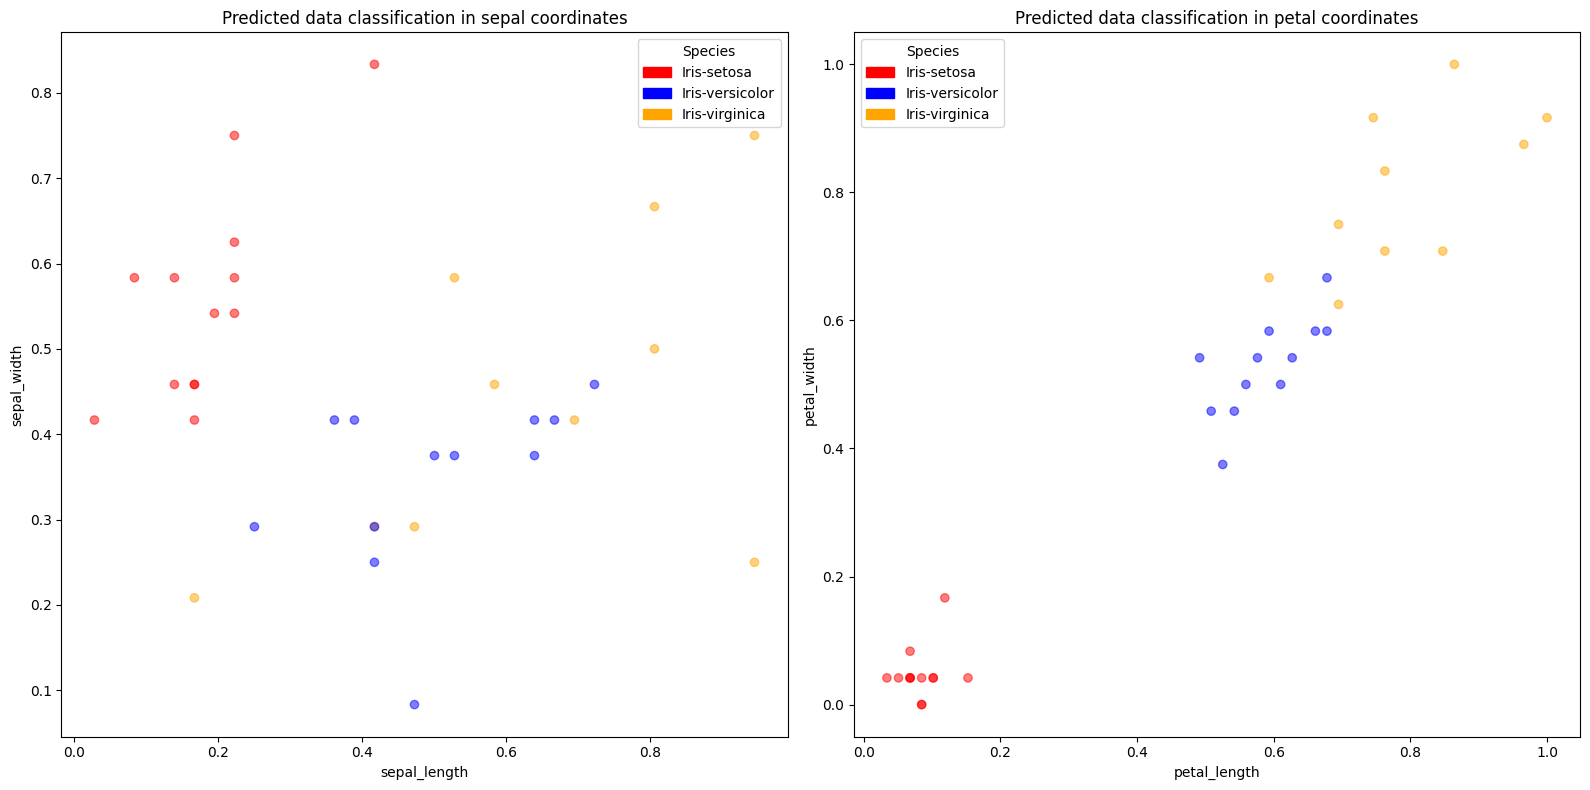

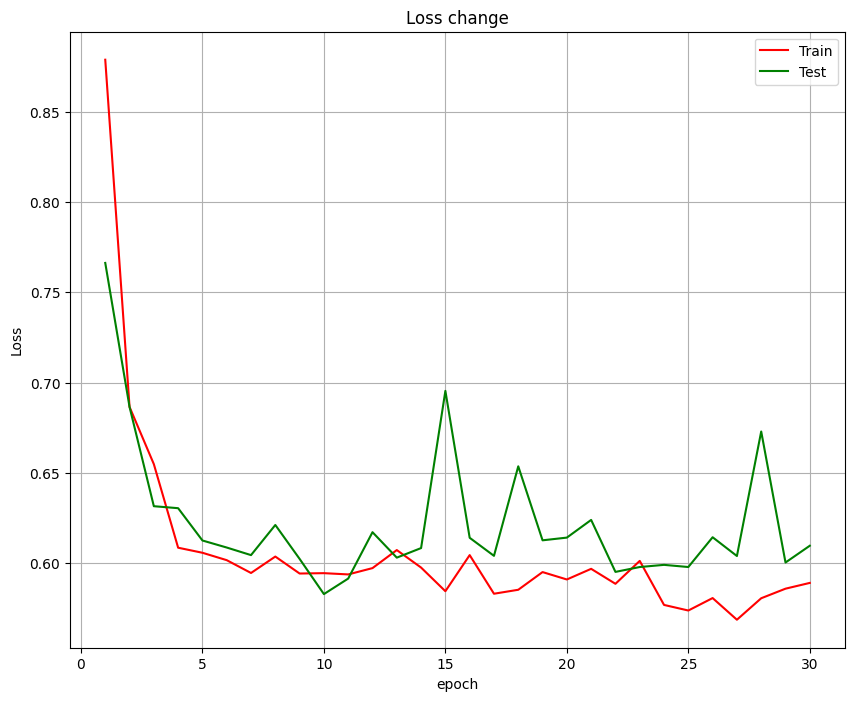

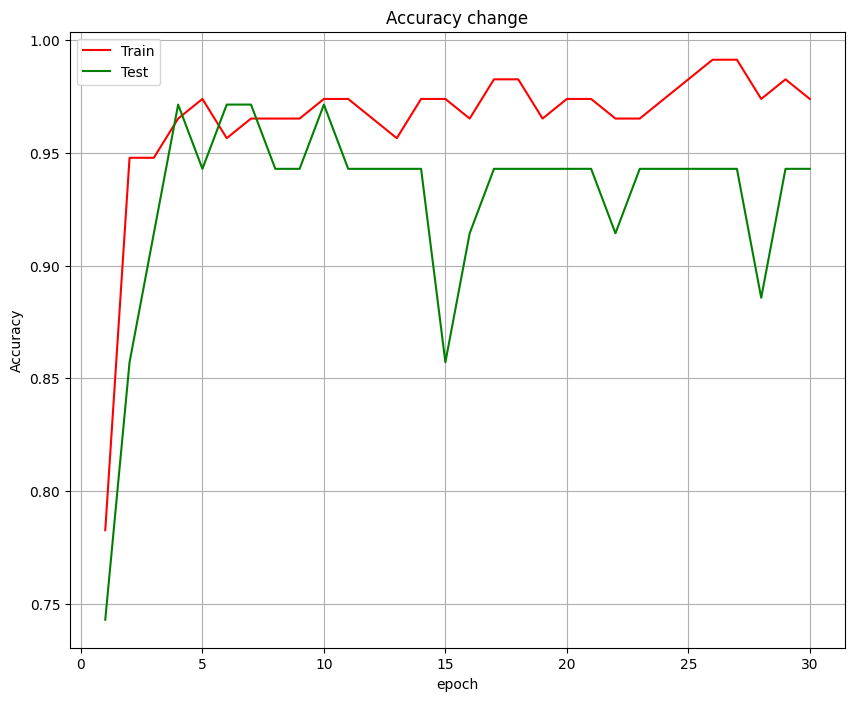

In [62]:
train_dataset, test_dataset = get_iris_dataset()

start_time = time.time()

layers = [
    FullyConnected(128, LeakyRelu()),
    FullyConnected(128, LeakyRelu()),
    FullyConnected(128, LeakyRelu()),
    FullyConnected(3, Linear())
]
nn = NeuralNetwork(
    Input(4),
    layers,
    optimizer=Adam(),
    loss=CategoricalCrossEntropy(),
    metric=AccuracyOneHot(),
    convert_prediction='argmax'
)

epochs = 30
history = nn.fit(train_dataset, test_dataset, epochs=epochs, batch_size=1, verbose=True)

print("--- %s seconds ---" % (time.time() - start_time))

prediction, raw_pred = nn.predict(test_dataset, with_raw_prediction=True)

predicted = test_dataset.copy()

predicted = []
for index, predict in enumerate(prediction):
    predicted.append({
        'input': test_dataset[index]['input'],
        'output': predict.flatten().tolist()
    })

plot_iris(test_dataset, 'Original test data classification')
plot_iris(predicted, 'Predicted data classification')

epoch = [epoch_data['epoch'] for epoch_data in history]
train_loss = [epoch_data['train_loss'] for epoch_data in history]
test_loss = [epoch_data['test_loss'] for epoch_data in history]
train_metric = [epoch_data['train_metric'] for epoch_data in history]
test_metric = [epoch_data['test_metric'] for epoch_data in history]

plot_loss(epoch, train_loss, test_loss, "Loss change")
plot_accuracy_score(epoch, train_metric, test_metric, "Accuracy change")

# 2. Classification on digits dataset

## Function to display selected 

In [63]:
def plot_digit(image, digit):    
    image = torch.tensor(image).numpy().reshape(28, 28)
    plt.figure()
    plt.imshow(image, cmap="gray")
    plt.title(f"Predicted digit: {digit}")
    plt.axis("off")
    plt.show()

    return

## Helper function to get one-hot array for digit

In [64]:
def get_onehot_digit(digit):
    output = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]    
    return output[-digit:] + output[:-digit]

## Helper function to get digit by one-hot arrary

In [65]:
def get_digit(onehot_array):
    for index, value in enumerate(onehot_array):
        if value == 1.0:
            return index
    return None

## Function to get digits train/test data

In [66]:
def get_digits_data():

    train_dataset = []

    train = pd.read_csv("../data/digits/train.csv", header=0, nrows=5000)

    for index in train.index:
        input_values = [
            float(val) / 255.0 for val in train.loc[index].drop("label").values
        ]
        train_dataset.append(
            {
                "input": input_values,
                "output": get_onehot_digit(int(train.loc[index]["label"])),
            }
        )

    random.shuffle(train_dataset)
    return train_dataset[:2000], train_dataset[2000:2500]

## Create model for classification on digits dataset and test

Epoch: 1/20, train loss: 2.1201, train Accuracy: 0.461, test loss: 1.946, test Accuracy: 0.746
Epoch: 2/20, train loss: 1.8735, train Accuracy: 0.816, test loss: 1.826, test Accuracy: 0.856
Epoch: 3/20, train loss: 1.7747, train Accuracy: 0.8965, test loss: 1.7566, test Accuracy: 0.878
Epoch: 4/20, train loss: 1.7129, train Accuracy: 0.9245, test loss: 1.7228, test Accuracy: 0.888
Epoch: 5/20, train loss: 1.6711, train Accuracy: 0.9485, test loss: 1.6857, test Accuracy: 0.916
Epoch: 6/20, train loss: 1.6408, train Accuracy: 0.9635, test loss: 1.6772, test Accuracy: 0.912
Epoch: 7/20, train loss: 1.619, train Accuracy: 0.971, test loss: 1.6619, test Accuracy: 0.912
Epoch: 8/20, train loss: 1.5986, train Accuracy: 0.982, test loss: 1.6526, test Accuracy: 0.916
Epoch: 9/20, train loss: 1.5841, train Accuracy: 0.9875, test loss: 1.6387, test Accuracy: 0.918
Epoch: 10/20, train loss: 1.5683, train Accuracy: 0.991, test loss: 1.6311, test Accuracy: 0.92
Epoch: 11/20, train loss: 1.5574, trai

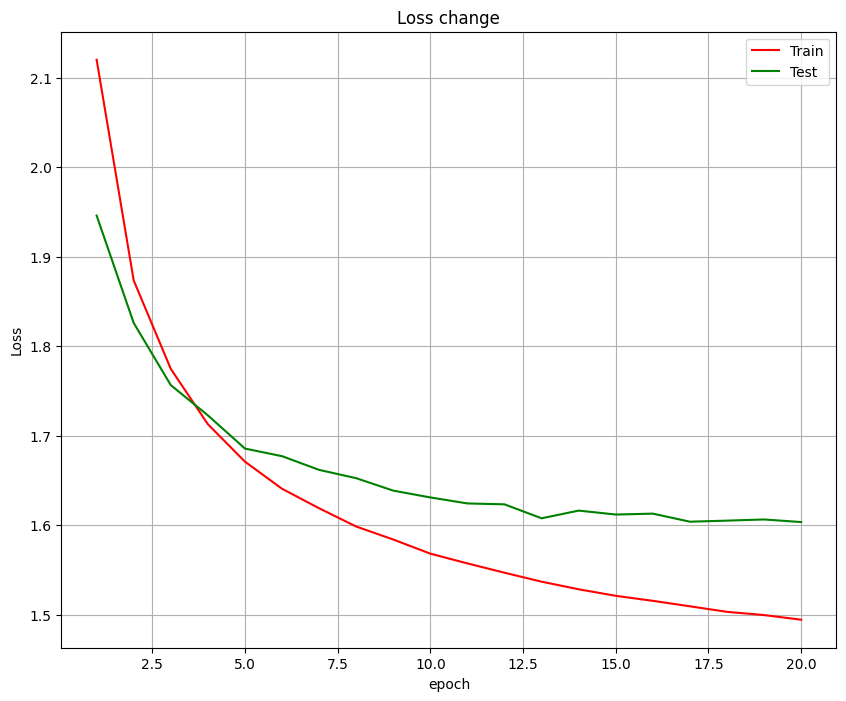

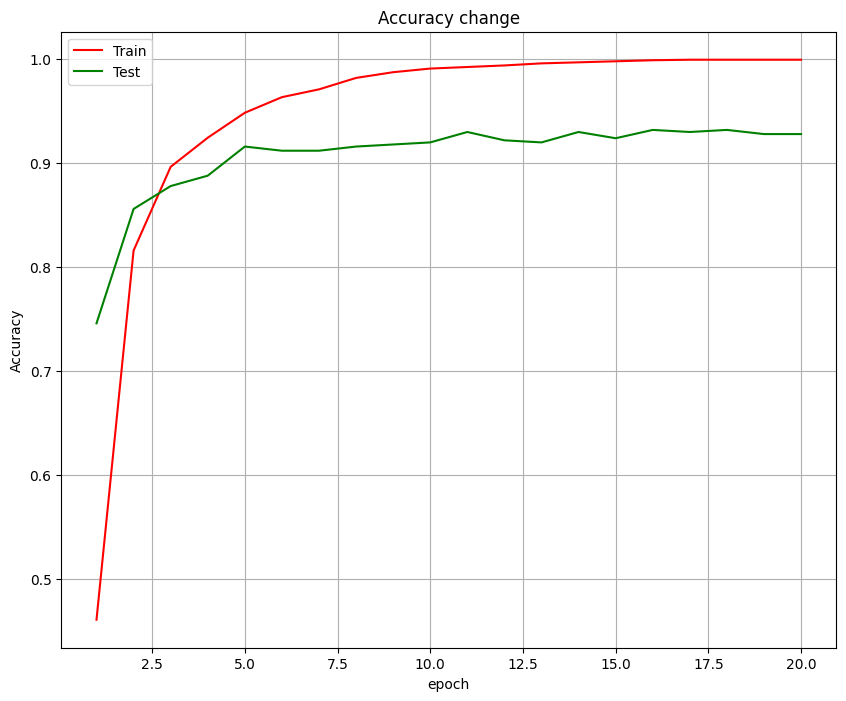

In [67]:
train_dataset, test_dataset = get_digits_data()

layers = [
    FullyConnected(256, LeakyRelu()),
    FullyConnected(128, LeakyRelu()),
    FullyConnected(64, LeakyRelu()),
    FullyConnected(10, Linear()),
]
nn = NeuralNetwork(
    Input(784),
    layers,
    optimizer=Adam(),
    loss=CategoricalCrossEntropy(),
    metric=AccuracyOneHot(),
    convert_prediction="argmax",
)

start_time = time.time()

epochs = 20
history = nn.fit(train_dataset, test_dataset, epochs=epochs, batch_size=8, verbose=True)

print("--- %s seconds ---" % (time.time() - start_time))

prediction = nn.predict(test_dataset)

epoch = [epoch_data['epoch'] for epoch_data in history]
train_loss = [epoch_data['train_loss'] for epoch_data in history]
test_loss = [epoch_data['test_loss'] for epoch_data in history]
train_metric = [epoch_data['train_metric'] for epoch_data in history]
test_metric = [epoch_data['test_metric'] for epoch_data in history]
    
plot_loss(epoch, train_loss, test_loss, "Loss change")
plot_accuracy_score(epoch, train_metric, test_metric, "Accuracy change")    

## First ten test digits with predicted values

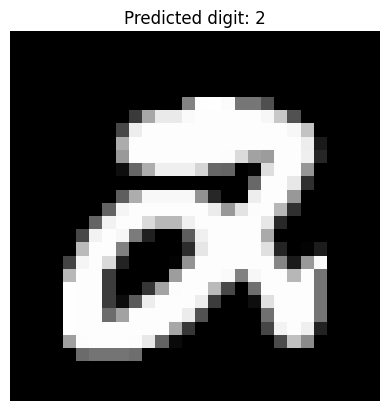

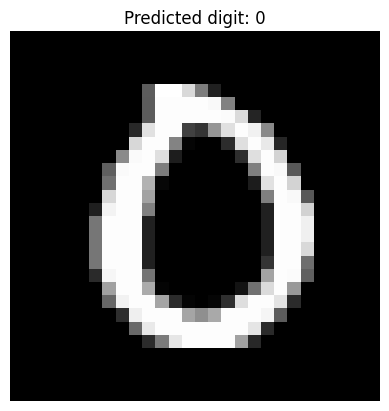

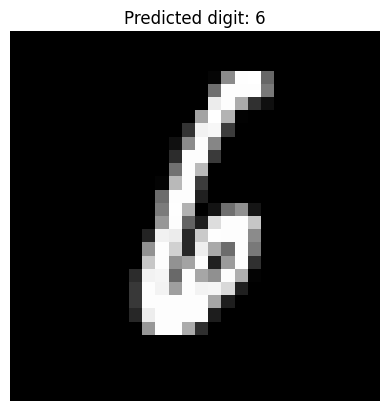

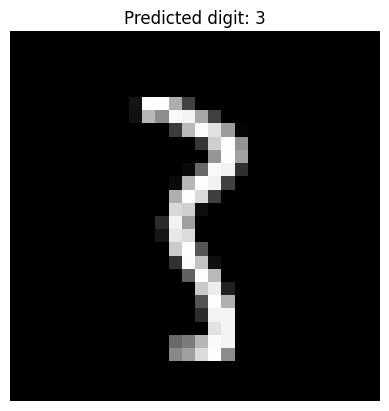

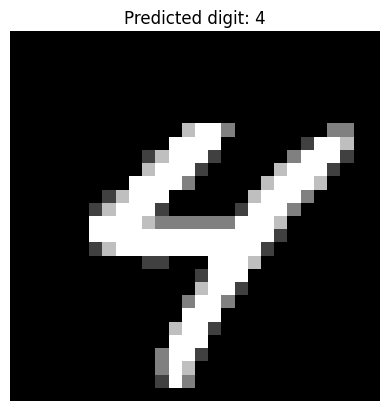

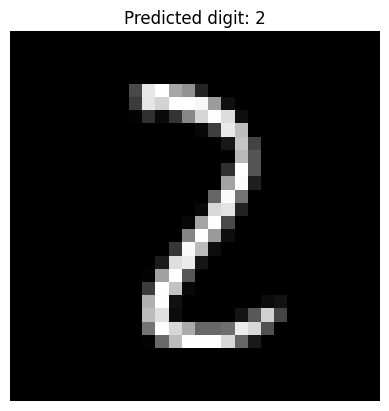

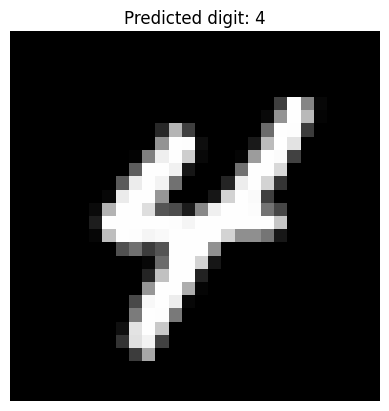

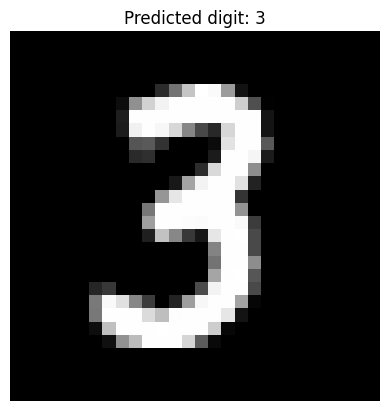

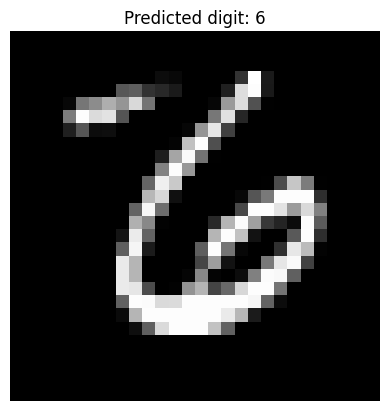

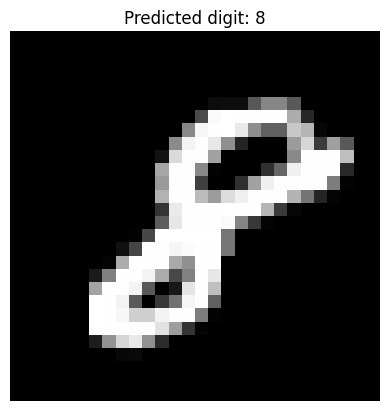

In [68]:
for index, predicted_digit in enumerate(prediction[:10]):
    plot_digit(test_dataset[index]['input'], get_digit(predicted_digit))